# Programming Assignment 3: Sentiment analysis

In this programming assignment, you will implement logistic regression to predict the sentiment of reviews that come from `imdb.com`, `amazon.com`, and `yelp.com`. Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [614]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [615]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

for i in range(5):
    print ('Label: ',y[i],'; ', sentences[i])

Label:  -1 ;  So there is no way for me to plug it in here in the US unless I go by a converter.
Label:  1 ;  Good case, Excellent value.
Label:  1 ;  Great for the jawbone.
Label:  -1 ;  Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
Label:  1 ;  The mic is great.


### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [616]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [617]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

What do the sentences look like so far?

In [618]:
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

**Task P1:** Once you get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term. What is the size of the resulting data_mat matrix?

In [619]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


In [620]:
## STUDENT: YOUR CODE STARTS HERE
# Task: Append '1' to the beginning of each vector.
# Hint: You can use data_features.toarray() to transform data_features into a numpy array
# The output should be a numpy array named data_mat

data_mat = data_features.toarray()

data_mat=np.insert(data_mat,0,1.,axis =1)

## STUDENT: CODE ENDS
print ('The updated size: ',data_mat.shape)

The updated size:  (3000, 4501)


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [621]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4501)
test data:  (500, 4501)


## 2. Fitting a logistic regression model to the training data

In this section, we will implement our own logistic regression solver using gradient descent. As we have seen in the class, to learn the parameters of logistic regression, we need to perform the following optimization:

$$
{\bf \tilde\theta}_t =
\underset{{\bf \tilde\theta}}{\operatorname{argmin}} \; L_\mathcal{D}({\bf \tilde\theta}) =
\underset{{\bf \tilde\theta}}{\operatorname{argmin}} \;\sum_{i=1}^{n} \ln \left( 1 + e^{y_i \; {\bf \tilde\theta}_t^T {\tilde x}_i} \right)
$$
where $y_i\in\{-1,+1\}$ is the label, ${\bf \tilde\theta}$ is the vector of coefficients:
$$
{\bf \tilde\theta} = \begin{bmatrix} \theta_0 & \theta_1 & ... & \theta_d \end{bmatrix}^T,
$$
and ${\tilde x}$ is the "augmented" feature vector (of $d+1$ dimensions), where we stick a 1 in the front of the original features:
$$
{\tilde x} = \begin{bmatrix} 1 & x_1 & ... & x_d \end{bmatrix}^T.
$$


There is no nice, closed-form solution like with [least-squares linear regression](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) so we will use [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) instead. Specifically we will use batch gradient descent which calculates the gradient from all data points in the data set. Luckily, the loss function $L_\mathcal{D}({\bf \tilde\theta})$ we want to minimize is [convex](http://en.wikipedia.org/wiki/Convex_optimization) so there is only one minimum. Thus the minimum we arrive at is the global minimum.

Gradient descent is a general method and requires twice differentiability for [smoothness](http://en.wikipedia.org/wiki/Smooth_function). It updates the parameters using a first-order approximation of the error surface.

$$
{\bf \tilde\theta}_{t+1} = {\bf \tilde\theta}_t + \nabla L_\mathcal{D}({\bf \tilde\theta}_t)
$$

**Task P2:** Derive the gradient of the loss $L_\mathcal{D}({\bf \tilde\theta})$ with respect to ${\bf \tilde\theta}$, namely $\nabla L_\mathcal{D}({\bf \tilde\theta}_t)$. The answer should depend on data points $(x_i,y_i)$ for $i=1,...,n$, and the model parameter ${\bf \tilde\theta}$. Make sure you get the sign correct. Also implement the function `weight_derivative`. Print the output of the code. 

In [622]:
def weight_derivative(weights, feature_matrix, labels):
    # Input:
    # weights: weight vector w, a numpy vector of dimension d
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the regression cost function with respect to the weight w, a numpy array of dimension d
        
    ## STUDENT: Start of code ###
    
    #    - yx
    #  ____________
    #   ((e^yθ^Tx)+1)
    
    #initialize ld(theta)
    derivatives=np.zeros(weights.size)

    for i in range(labels.size):
        #dot product of weigths with each column of feature matrix
        column_product=np.dot(weights,feature_matrix[i,:])
        temp=labels[i]*column_product
        value = 1/(1+np.exp(temp))
        #take the sum for every road
        derivatives = derivatives+(- labels[i]*feature_matrix[i,:]*value)
        
    return derivatives  

    # End of code ###

In [623]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
my_weights = np.ones(data_mat.shape[1]) # a weight of all 1s
derivative = weight_derivative(my_weights,train_data,train_labels)


print (derivative[:10])

[ 1.23415330e+03 -4.13993755e-08  1.00000000e+00  9.99993856e-01
  1.99987630e+00  9.99859072e-01  9.52574127e-01  3.59772270e+01
  2.99996572e+00 -1.38879439e-11]


Now, we can just use the same gradient descent algorithm that we wrote in assignment 2 to solve it.

In [ ]:
def gradient_descent(feature_matrix, labels, initial_weights, step_size, tolerance):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_weights: initial weight vector to start with, a numpy vector of dimension d
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Output:
    # Weights obtained after convergence

    converged = False 
    weights = np.array(initial_weights) # current iterate
    i = 0
    
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        derivative = np.array(weight_derivative(weights, feature_matrix, labels))
        #print(step_size*derivative)
        weights -= (step_size * derivative)
       
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(derivative**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        
       
        if (gradient_magnitude < tolerance):
            converged = True
        
        print ("Iteration: ",i,"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(weights)

**Task P3:** Specify the initial_weights, step_size, and tolerance for the function `gradient_descent`. Copy the outputs of the code to the solution file.

In [644]:
#Initialize the weights, step size and tolerance
# Start of code
#STUDENT: Specify the initial_weights, step_size, and tolerance

temp_weight = [0.5]*(len(train_data[0]))
initial_weights = np.array(temp_weight)
#print(initial_weights)


step_size = 2
tolerance = 2
# end of code

# Use the regression_gradient_descent function to calculate the gradient decent and store it in the variable 'final_weights'
final_weights = gradient_descent(train_data,train_labels, initial_weights, step_size, tolerance)

# end of code
print ("Here are the final weights after convergence:")
print (final_weights)

Iteration:  1 gradient_magnitude:  1417.6129100613616
Iteration:  2 gradient_magnitude:  1573.259355605426
Iteration:  3 gradient_magnitude:  1291.3793043542978
Iteration:  4 gradient_magnitude:  1573.259355605426
Iteration:  5 gradient_magnitude:  1493.4879431356328
Iteration:  6 gradient_magnitude:  1572.127857395829
Iteration:  7 gradient_magnitude:  1389.4120202171252
Iteration:  8 gradient_magnitude:  1547.9211801082454
Iteration:  9 gradient_magnitude:  1400.8397808294674
Iteration:  10 gradient_magnitude:  1423.7696432810585
Iteration:  11 gradient_magnitude:  1333.317358974452
Iteration:  12 gradient_magnitude:  1277.138306824494
Iteration:  13 gradient_magnitude:  1244.2778248794955
Iteration:  14 gradient_magnitude:  1210.1461014971637
Iteration:  15 gradient_magnitude:  1205.058972957471
Iteration:  16 gradient_magnitude:  1193.212271347353
Iteration:  17 gradient_magnitude:  1182.244631804018
Iteration:  18 gradient_magnitude:  1179.1263641832315
Iteration:  19 gradient_mag

Iteration:  151 gradient_magnitude:  87.59044063961097
Iteration:  152 gradient_magnitude:  93.14357549653658
Iteration:  153 gradient_magnitude:  101.98874999358657
Iteration:  154 gradient_magnitude:  107.79357858989196
Iteration:  155 gradient_magnitude:  113.53852789009858
Iteration:  156 gradient_magnitude:  110.84071508990469
Iteration:  157 gradient_magnitude:  85.69028468501882
Iteration:  158 gradient_magnitude:  63.146889126469986
Iteration:  159 gradient_magnitude:  35.680474017389564
Iteration:  160 gradient_magnitude:  19.62838101643654
Iteration:  161 gradient_magnitude:  15.044064056951033
Iteration:  162 gradient_magnitude:  14.881977192533368
Iteration:  163 gradient_magnitude:  16.884799818787943
Iteration:  164 gradient_magnitude:  20.99612830813034
Iteration:  165 gradient_magnitude:  28.46616335552794
Iteration:  166 gradient_magnitude:  38.54231613360385
Iteration:  167 gradient_magnitude:  49.53342011092665
Iteration:  168 gradient_magnitude:  65.89399629922268
I

Iteration:  300 gradient_magnitude:  5.776558030925981
Iteration:  301 gradient_magnitude:  3.4454576386039815
Iteration:  302 gradient_magnitude:  2.8891066710720694
Iteration:  303 gradient_magnitude:  2.8142806000520424
Iteration:  304 gradient_magnitude:  2.7745649641453243
Iteration:  305 gradient_magnitude:  2.9011307721678574
Iteration:  306 gradient_magnitude:  4.282728345857269
Iteration:  307 gradient_magnitude:  8.915377546753835
Iteration:  308 gradient_magnitude:  9.978338344005941
Iteration:  309 gradient_magnitude:  12.375388776550794
Iteration:  310 gradient_magnitude:  14.374213361365427
Iteration:  311 gradient_magnitude:  14.889701429733611
Iteration:  312 gradient_magnitude:  11.391844876941724
Iteration:  313 gradient_magnitude:  4.205711373895891
Iteration:  314 gradient_magnitude:  2.8736410651141124
Iteration:  315 gradient_magnitude:  2.819016442841977
Iteration:  316 gradient_magnitude:  2.7819374339541643
Iteration:  317 gradient_magnitude:  2.705978008565047

**Task P4:** Write the code to extract the y-intercept $\theta_0$ and the rest of the parameters $\theta= \begin{bmatrix} \theta_1 & ... & \theta_d \end{bmatrix}^T$. Copy the code and print the outputs.

In [635]:
## STUDENT: CODE STARTS HERE
## Pull out the parameters (theta_0, theta) of the logistic regression model

theta =  final_weights #gradient_descent(train_data,train_labels, initial_weights, step_size, tolerance)
theta0 = theta[0]
theta = np.delete(theta,0)

## STUDENT: CODE ENDS HERE

print ('y intercept: ',theta0)
print ('theta1 and theta2: ',theta[1],theta[2])


y intercept:  5.301077114064977
theta1 and theta2:  -152.5 -317.50000000000006


Recall that the [logistic/sigmoid function](http://en.wikipedia.org/wiki/Logistic_function) is given by

$$
f(z)=\frac{1}{1+e^{-z}}
$$

Based on the logistic model, the posterior probability

$$
P(y\mid{\bf x})=f(y\; {\bf \tilde \theta}^T {\bf \tilde x})
$$

To make a prediction, we can simply choose the label $y\in\{-1,+1\}$ with the higher posterior probability.

**Task P5:** Write the code to make the prediction for a given data matrix. Report the training error and test error.

In [636]:
def model_predict(feature_matrix,weights):
# Prediction made by logistic regression   
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    ## STUDENT: YOUR CODE HERE
    predict_array = []
   
    for i in range(len(feature_matrix)):
       
        dot = np.dot(feature_matrix[i],weights)
        
        z = -1*dot
        predict = 1/(1+pow(np.e,z))
        predict_array.append(predict)
    return np.array(predict_array)
    ## STUDENT: CODE ENDS
    

In [637]:
# STUDENT: copy the output of this section to the solution file
def getError(preds_train,train_labels):
    errs_train =  0
    for i in range(len(preds_train)):
        if((preds_train[i] > 0.0) and (train_labels[i] < 0.0)):
            errs_train+=1
        if((preds_train[i] < 0.0) and (train_labels[i] > 0.0)):
            errs_train+=1
    return errs_train
    
## Get predictions on training and test data
preds_train = model_predict(train_data,final_weights)
#print(preds_train)
preds_test = model_predict(test_data,final_weights)


## Compute errors

errs_train = np.sum((preds_train > 0.0) is not (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) is not (test_labels > 0.0))

error_train = getError(preds_train,train_labels)
error_test = getError(preds_test,test_labels)
    
    

print ("Training error: ", float(errs_train)/len(train_labels))
print ("Test error: ", float(errs_test)/len(test_labels))

print ("Training error: ", float(error_train)/len(train_labels))
print ("Test error: ", float(error_test)/len(test_labels))

Training error:  0.0004
Test error:  0.002
Training error:  0.1028
Test error:  0.184


C:\Users\kuent\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


## 3. Analyzing the margin

As discussed in the lecture, the logistic regression model produces not just classifications but also conditional probability estimates. 

We will say that `x` has **margin** `gamma` if (according to the logistic regression model) `Pr(y=1|x) > (1/2)+gamma` or `Pr(y=1|x) < (1/2)-gamma`. For example, if `Pr(y=1|x)` is 0.7 according to the logistic regression model, then the margin is 0.2. If `Pr(y=1|x)` is 0.15 according to the logistic regression model, then the margin is 0.35.

**Task P6:** Implement the following function **margin_counts** that takes as input the learned weights $\bf\tilde\theta$, the feature matrix (`feature_matrix`), and a value of `gamma`, and computes how many points in the data have margin at least `gamma`. Copy the code and the output plot (i.e., visualization of the test set's distribution of margin values) to the solution file.

In [638]:
def margin_counts(feature_matrix, weights, gamma):
## Return number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    model_predict_arr = model_predict(feature_matrix, weights)
    count =0;
    for i in range(len(model_predict_arr)):
        if (model_predict_arr[i]>0) and (model_predict_arr[i]<1):
            if(model_predict_arr[i]<0.5-gamma) or (model_predict_arr[i]>0.5+gamma):
                count+=1
    
    return count

    ## STUDENT: CODE ENDS

We now visualize the test set's distribution of margin values.

C:\Users\kuent\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


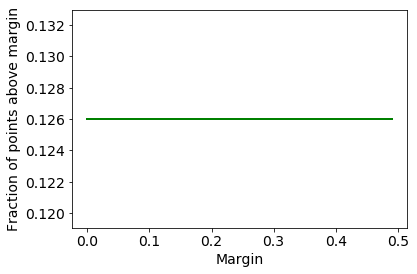

In [639]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_counts(test_data, final_weights,g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Next, we investigate a natural question: Are points `x` with larger margin more likely to be classified correctly?

To address this, we define a function **margin_errors** that computes the fraction of points with margin at least `gamma` that are misclassified.

**Task P7:** Implement the function `margin_errors` that computes the fraction of points with margin at least `gamma` that are misclassified. Copy the code and the output plot (i.e., visualization of the relationship between margin and error rate) to the solution file. What do you observe from the plot?

In [640]:
def margin_errors(feature_matrix, labels, weights, gamma):
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # labels: true labels y, a numpy vector of dimension n
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    model_predict_arr = model_predict(feature_matrix, weights)
    denominator=len(feature_matrix)
    numerator = 1
    
    for i in range(len(model_predict_arr)):
        if (model_predict_arr[i]>0) and (model_predict_arr[i]<1):
            if(model_predict_arr[i]<(0.5-gamma)) or (model_predict_arr[i]>(0.5+gamma)):
                denominator+=1
                if(labels[i]<(0.5-gamma)) and (model_predict_arr[i]<(0.5-gamma)):
                    numerator+=1
                if(labels[i]>(0.5+gamma)) and (model_predict_arr[i]>(0.5+gamma)):
                    numerator+=1
              
            
   
    return numerator/denominator

    ## STUDENT: YOUR CODE ENDS

We now visualize the relationship between margin and error rate.

C:\Users\kuent\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


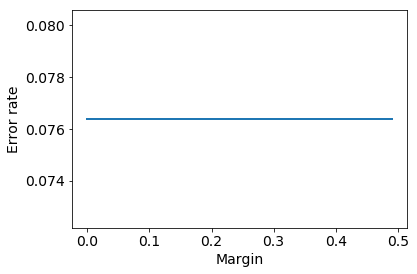

In [641]:
## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(test_data, test_labels,final_weights, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

## 4. Words with large influence

Finally, we attempt to partially **interpret** the logistic regression model.

Which words are most important in deciding whether a sentence is positive? As a first approximation to this, we simply take the words whose coefficients in $\theta$ have the largest positive values.

Likewise, we look at the words whose coefficients in $\theta$ have the most negative values, and we think of these as influential in negative predictions.

**Task P8:** Report the top 10 positive words (i.e., words with the largest positive coefficients of $\theta$) and the top 10 negative words (i.e., words with the most negative coefficients of $\theta$). 

In [642]:
## Convert vocabulary into a list:
## This is a list where the i-th entry corresponds to the 

vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])


## STUDENT: YOUR CODE HERE
#the first index is the larges value and the last index is the smallest value
#the value that is going to be excluded firrst from the array is in the back

weights= np.delete(final_weights,0)
print(len(weights))
large_positive = []
small_negative = []
                  
for i in range(len(weights)):
    #initialize array
    if (len(large_positive)<10):
        large_positive.append([vocab[i],weights[i]])
        small_negative.append([vocab[i],weights[i]])
    else:
        #larger than smallest value in array
        if (final_weights[i]>large_positive[0][1]):
            #remove small add large
            large_positive.pop(0)
            large_positive.append([vocab[i],weights[i]])
            large_positive.sort(key=lambda x: x[1])
        #smaller than largest value in array
        if (final_weights[i]<small_negative[9][1]):
            #remove large add small
            small_negative.pop(9)
            small_negative.append([vocab[i],weights[i]])
            small_negative.sort(key=lambda x: x[1])

#remove weights from print statement
final_positive = []
final_negative = []
for i in range(10):
    final_positive.append(large_positive[i][0])
    final_negative.append(small_negative[i][0])
    

print('Top Ten')
print(large_positive)
print('Bottom Ten')
print(small_negative)

## STUDENT: CODE ENDS

4500
Top Ten
[['you', 522.3124682700212], ['well', 1198.4122353355472], ['family', 1267.4999997273922], ['happy', 1507.5298332164937], ['friendly', 1609.6197732734986], ['amazing', 1756.0169505164492], ['works', 1953.3096254243846], ['fantastic', 2054.3429738609047], ['loved', 2349.88442359567], ['great', 2382.2088423393316]]
Bottom Ten
[['worst', -2435.1562271465036], ['disappointment', -2236.3075883660986], ['waste', -2118.928162274578], ['disappointing', -1820.0104102997275], ['avoid', -1655.739111789458], ['bland', -1609.8454208770834], ['fails', -1431.4384892762353], ['aren', -1322.6989221304673], ['difficult', -1264.999999999803], ['writing', -824.9671458584996]]


## 5. (Bonus question) Classifiers that can abstain

Suppose you are building a classifier, and can tolerate an error rate of at most some value `e`. Unfortunately, every classifier you try has a higher error than this. 

Therefore, you decide that the classifier is allowed to occasionally **abstain**: that is, to say *"don't know"*. When it actually makes a prediction, it must have error rate at most `e`. And subject to this constraint, it should abstain as infrequently as possible.

How would you build an abstaining classifier of this kind, starting from a logistic regression model? To get the bonus score, you need to show the following:

* A general description of the method
* Your code implementation
* A case study to show how you can use it in practice (including necessary plots)

In [613]:
## STUDENT: YOUR CODE HERE


## STUDENT: CODE ENDS